In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import pandas_datareader.data as web
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix as matrix

In [4]:
#import and clean Covid data
covid_raw = pd.read_csv(r"C:\Users\sclark\OneDrive - Navigant Consulting Inc\Documents\UMD Data Science\Principals of Data Science\Final Project\Data\COVID\United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv")
variables = ["submission_date", "tot_cases", "new_case", "tot_death", "new_death"]
covid = covid_raw.loc[:,variables]
covid.corr()

,tot_cases,new_case,tot_death,new_death
tot_cases,1.000000,0.643093,0.757769,0.273258
new_case,0.643093,1.000000,0.378437,0.436530
tot_death,0.757769,0.378437,1.000000,0.243978
new_death,0.273258,0.436530,0.243978,1.000000


In [5]:
#converting datetime and grouping weekly and by state
covid["submission_date"]=pd.to_datetime(covid["submission_date"])
covid.rename(columns={"submission_date":"Date"}, inplace=True)

In [6]:
#group weekly
weekly_covid = covid.groupby(pd.Grouper(key = "Date", freq ="W")).sum()
weekly_covid.reset_index(inplace=True)
weekly_covid.head()

#percent change
weekly_covid["percent_change_cases"] = weekly_covid["new_case"].diff().fillna(0)/weekly_covid["new_case"]
weekly_covid["percent_change_deaths"] = weekly_covid["new_death"].diff().fillna(0)/weekly_covid["new_death"]
weekly_covid["percent_change_deaths"] = weekly_covid["percent_change_deaths"].fillna(0)

In [7]:
#lists for stocks
energyStocks = ["CVX","XOM","KMI","WMB","LNG"]
retailStocks = ["WMT","AMZN","COST","BIG","ACI"]
bioStock = ["FBRX", "TRIL", "CODX", "ALIM", "BTAI"]
pharmStock = ["ABT", "RCUS", "LLY", "ELAN", "MRK"]

stocklist = energyStocks + bioStock + pharmStock

In [9]:
#cleaning stock data
start = "2020-01-22"
end = dt.now()

stocks = pd.DataFrame()

covid_stocks = pd.DataFrame()

for x in stocklist:
    df = web.DataReader(x, "yahoo", start, end)
    df.reset_index(inplace=True)
    
    weekly_stock = df.groupby([pd.Grouper(key="Date", freq="W")]).mean()
    weekly_stock["Stock"] = x
    weekly_stock.reset_index(inplace = True)
    
    weekly_stock["percent_change_stock"] = weekly_stock["Adj Close"].diff().fillna(0)/weekly_stock["Adj Close"]
    
    weekly_stock["Rise/Fall"] = np.where(weekly_stock["percent_change_stock"]>0, "Rise", "fall")
    
    stocks = stocks.append(weekly_stock[["Date","Stock", "percent_change_stock", "Rise/Fall"]], ignore_index=True)

    covid_stocks = pd.merge(stocks, weekly_covid, on="Date")    

covid_stocks["Category"] = ""
covid_stocks.loc[covid_stocks["Stock"].isin(energyStocks), "Category"] = "energyStocks"
covid_stocks.loc[covid_stocks["Stock"].isin(retailStocks), "Category"] = "retailStocks"
covid_stocks.loc[covid_stocks["Stock"].isin(bioStock), "Category"] = "bioStock"
covid_stocks.loc[covid_stocks["Stock"].isin(pharmStock), "Category"] = "pharmStock"


In [10]:
covid_stocks_dummies = pd.concat([covid_stocks, pd.get_dummies(covid_stocks["Category"], prefix="Dummy")], axis = 1)
covid_stocks_dummies.corr()

,percent_change_stock,tot_cases,new_case,tot_death,new_death,percent_change_cases,percent_change_deaths,Dummy_bioStock,Dummy_energyStocks,Dummy_pharmStock
percent_change_stock,1.000000,-1.105861e-02,6.049059e-02,1.002296e-02,2.197383e-01,-1.743078e-01,-8.857596e-02,6.747504e-02,-7.589048e-02,8.415441e-03
tot_cases,-0.011059,1.000000e+00,7.803330e-01,9.600863e-01,1.205872e-01,-2.222263e-01,-3.240718e-01,1.196699e-17,1.468290e-17,1.307033e-17
new_case,0.060491,7.803330e-01,1.000000e+00,8.301647e-01,4.149966e-01,-1.801475e-01,-2.713861e-01,-8.919329e-18,-1.995410e-17,-1.515801e-17
tot_death,0.010023,9.600863e-01,8.301647e-01,1.000000e+00,2.243083e-01,-2.392039e-01,-4.073980e-01,-8.051039e-19,-7.584312e-19,-1.197154e-17
new_death,0.219738,1.205872e-01,4.149966e-01,2.243083e-01,1.000000e+00,-2.158625e-01,-1.688688e-01,1.149140e-17,3.002593e-17,2.668971e-17
percent_change_cases,-0.174308,-2.222263e-01,-1.801475e-01,-2.392039e-01,-2.158625e-01,1.000000e+00,7.892376e-01,1.922169e-18,-1.345518e-17,-1.345518e-17
percent_change_deaths,-0.088576,-3.240718e-01,-2.713861e-01,-4.073980e-01,-1.688688e-01,7.892376e-01,1.000000e+00,9.004547e-19,-2.701364e-18,-1.440728e-17
Dummy_bioStock,0.067475,1.196699e-17,-8.919329e-18,-8.051039e-19,1.149140e-17,1.922169e-18,9.004547e-19,1.000000e+00,-5.000000e-01,-5.000000e-01
Dummy_energyStocks,-0.075890,1.468290e-17,-1.995410e-17,-7.584312e-19,3.002593e-17,-1.345518e-17,-2.701364e-18,-5.000000e-01,1.000000e+00,-5.000000e-01
Dummy_pharmStock,0.008415,1.307033e-17,-1.515801e-17,-1.197154e-17,2.668971e-17,-1.345518e-17,-1.440728e-17,-5.000000e-01,-5.000000e-01,1.000000e+00


In [11]:
finalVars = ["Rise/Fall","percent_change_cases","percent_change_deaths","percent_change_stock","Dummy_bioStock", "Dummy_energyStocks","Dummy_pharmStock"]
final = covid_stocks_dummies.loc[:,finalVars]
final.corr()

,percent_change_cases,percent_change_deaths,percent_change_stock,Dummy_bioStock,Dummy_energyStocks,Dummy_pharmStock
percent_change_cases,1.000000e+00,7.892376e-01,-0.174308,1.922169e-18,-1.345518e-17,-1.345518e-17
percent_change_deaths,7.892376e-01,1.000000e+00,-0.088576,9.004547e-19,-2.701364e-18,-1.440728e-17
percent_change_stock,-1.743078e-01,-8.857596e-02,1.000000,6.747504e-02,-7.589048e-02,8.415441e-03
Dummy_bioStock,1.922169e-18,9.004547e-19,0.067475,1.000000e+00,-5.000000e-01,-5.000000e-01
Dummy_energyStocks,-1.345518e-17,-2.701364e-18,-0.075890,-5.000000e-01,1.000000e+00,-5.000000e-01
Dummy_pharmStock,-1.345518e-17,-1.440728e-17,0.008415,-5.000000e-01,-5.000000e-01,1.000000e+00


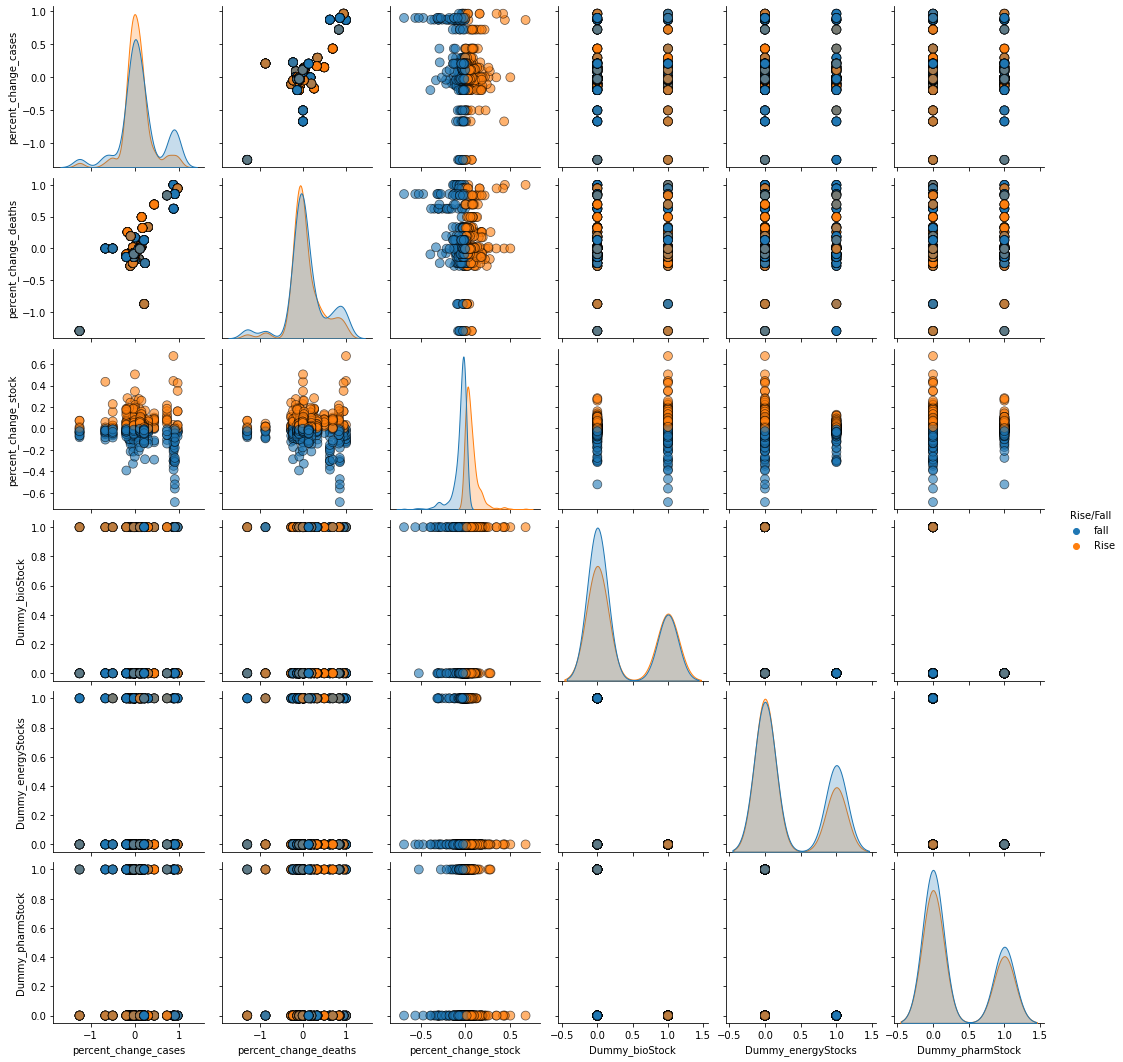

In [12]:
#pairplots
import seaborn as sns

sns.pairplot(final, hue = "Rise/Fall", diag_kind = "kde", plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'})

In [13]:
final.corr()

,percent_change_cases,percent_change_deaths,percent_change_stock,Dummy_bioStock,Dummy_energyStocks,Dummy_pharmStock
percent_change_cases,1.000000e+00,7.892376e-01,-0.174308,1.922169e-18,-1.345518e-17,-1.345518e-17
percent_change_deaths,7.892376e-01,1.000000e+00,-0.088576,9.004547e-19,-2.701364e-18,-1.440728e-17
percent_change_stock,-1.743078e-01,-8.857596e-02,1.000000,6.747504e-02,-7.589048e-02,8.415441e-03
Dummy_bioStock,1.922169e-18,9.004547e-19,0.067475,1.000000e+00,-5.000000e-01,-5.000000e-01
Dummy_energyStocks,-1.345518e-17,-2.701364e-18,-0.075890,-5.000000e-01,1.000000e+00,-5.000000e-01
Dummy_pharmStock,-1.345518e-17,-1.440728e-17,0.008415,-5.000000e-01,-5.000000e-01,1.000000e+00


In [33]:
#dropped date because i was getting an error
    #found out that date needs to be converted to categorical data to work
    #in the tree
Y = final["Rise/Fall"]
features = ["percent_change_cases","percent_change_deaths"]
X = final.loc[:,features]

In [34]:
# Spliting Data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(430, 2) (430,)
(185, 2) (185,)


In [35]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_train, Y_train)

In [36]:
#get sorted labels for plot 
import numpy as np
sorted = Y.unique()
sorted = np.sort(sorted)
sorted = list(map(str, sorted))
sorted

['Rise', 'fall']

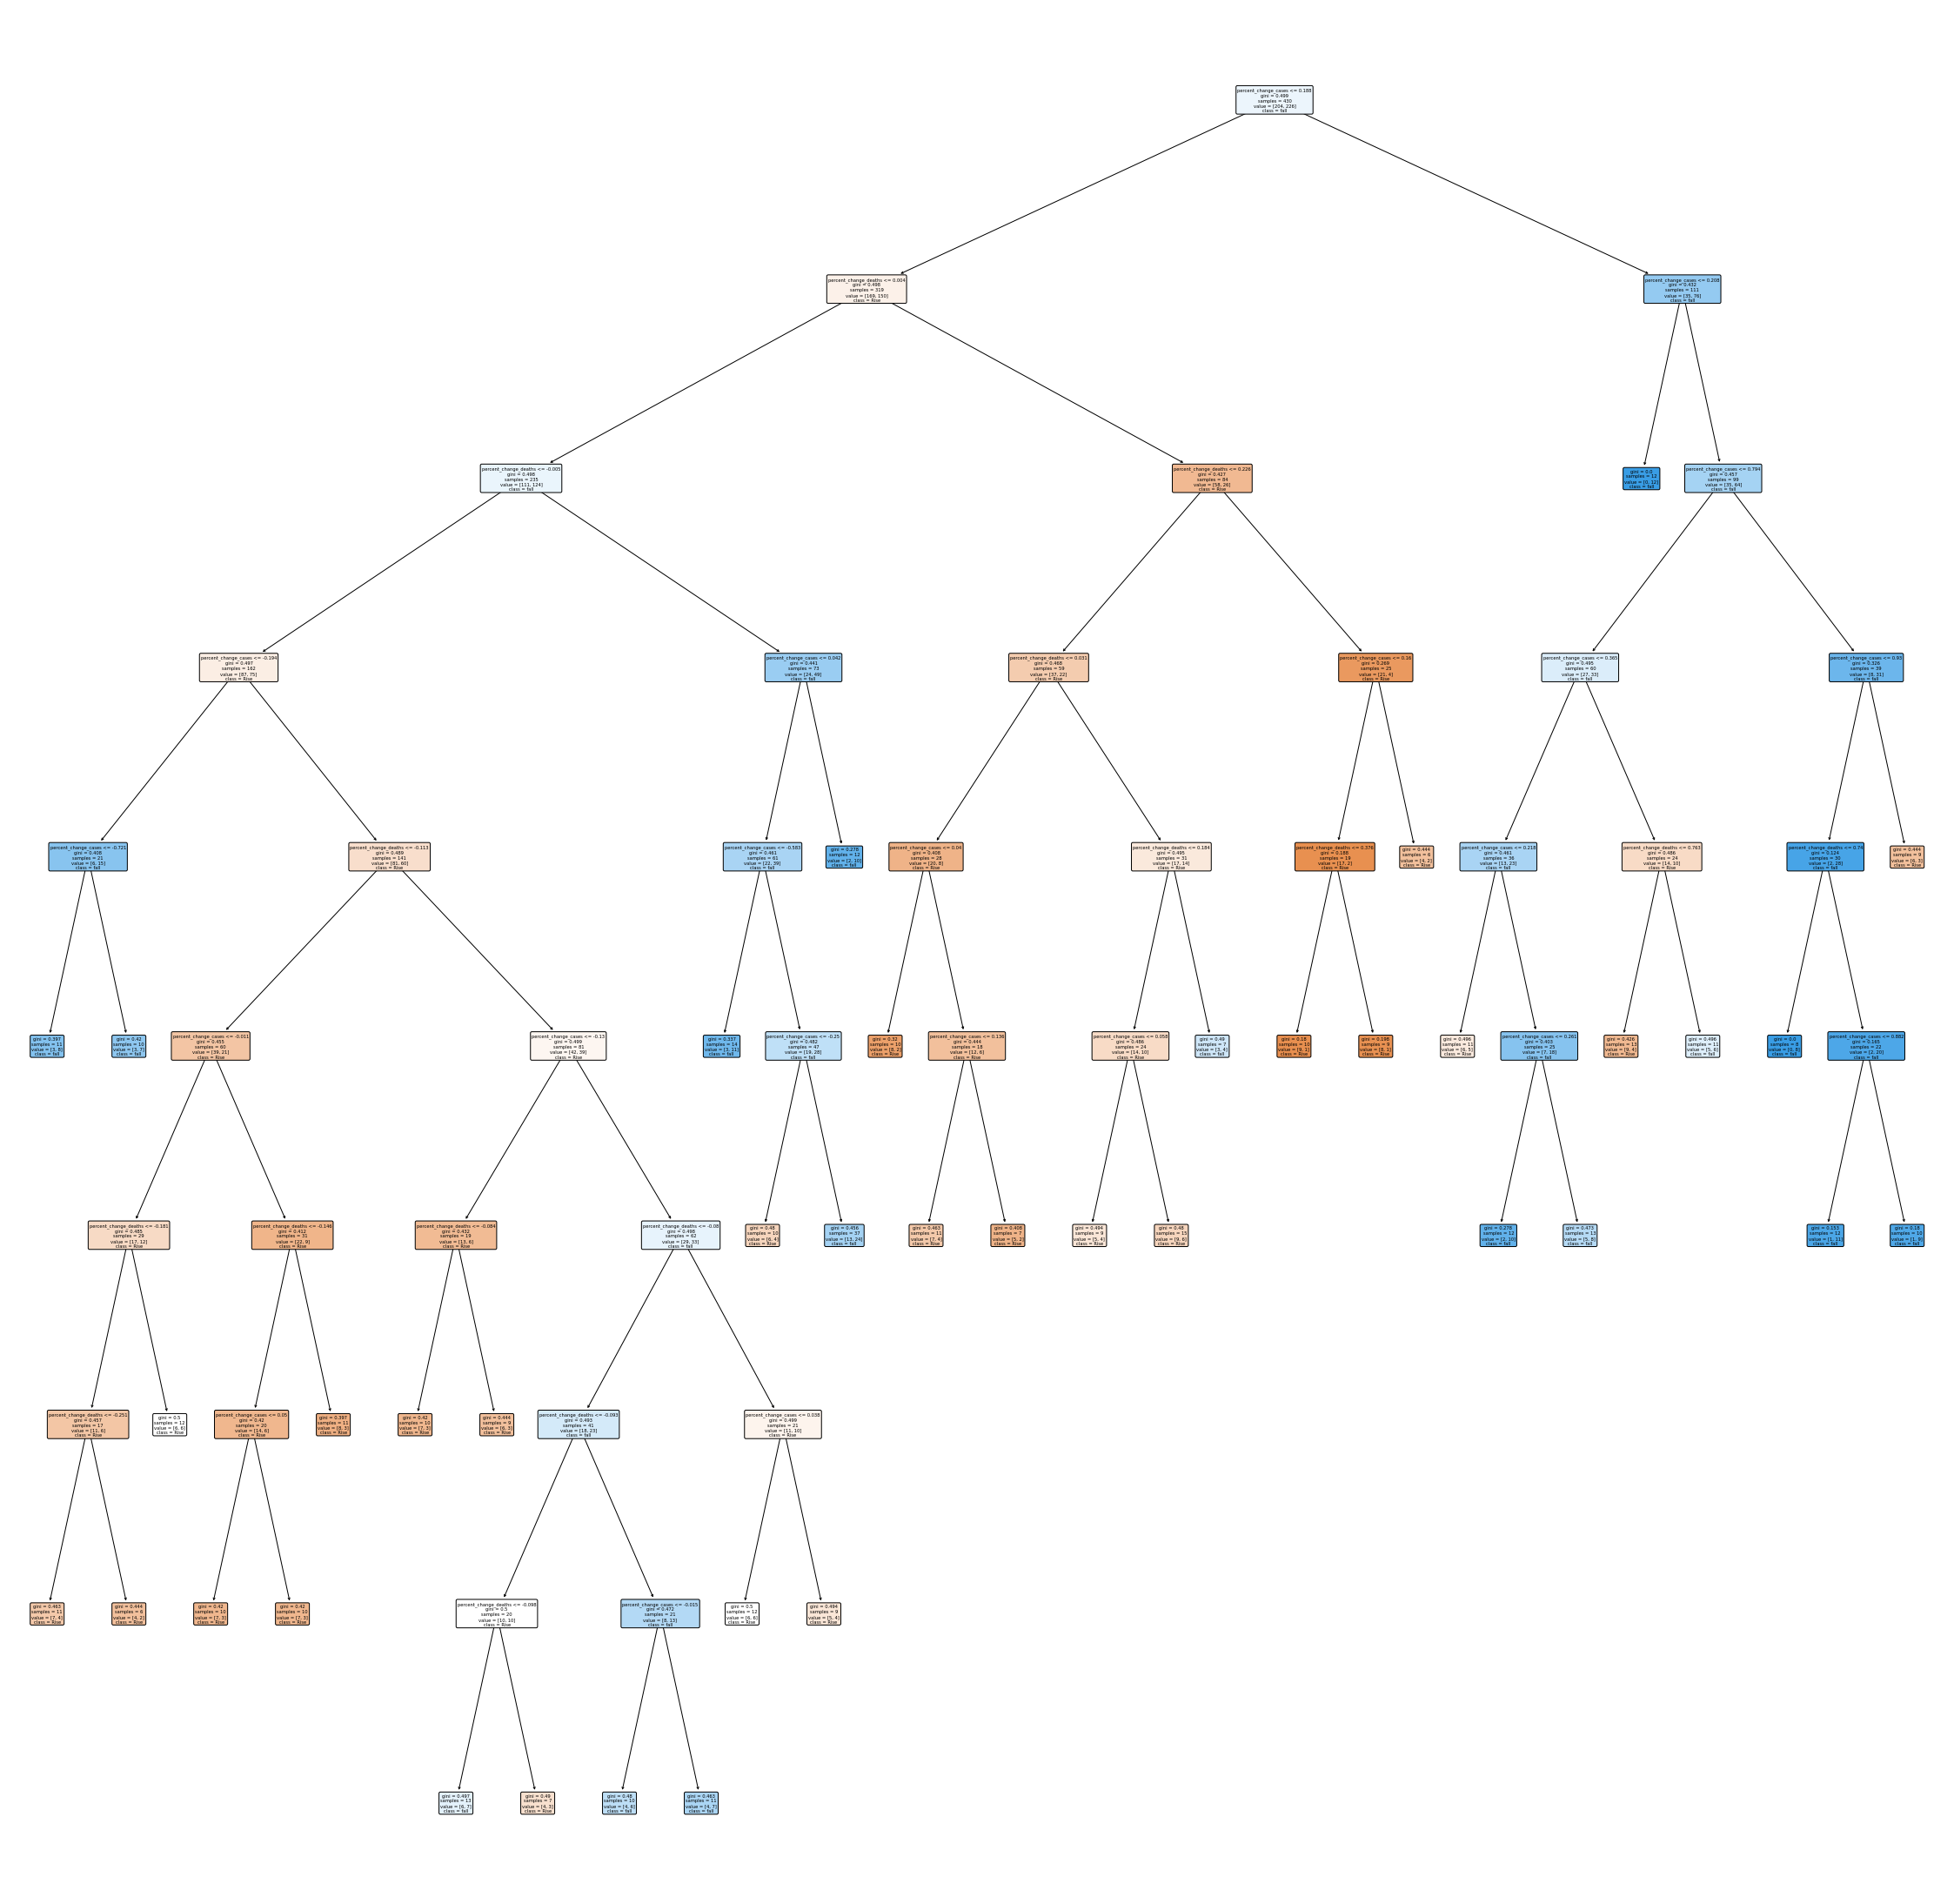

In [37]:
plt.subplots(figsize=(40, 40))
x = tree.plot_tree(clf,rounded=True,filled=True,class_names=sorted,feature_names=features) 


In [38]:
YPredicted = clf.predict(X_test)
YPredicted

array(['fall', 'fall', 'fall', 'Rise', 'fall', 'Rise', 'Rise', 'fall',
       'Rise', 'Rise', 'Rise', 'fall', 'Rise', 'fall', 'Rise', 'fall',
       'fall', 'Rise', 'fall', 'fall', 'Rise', 'Rise', 'fall', 'Rise',
       'fall', 'fall', 'fall', 'Rise', 'fall', 'fall', 'Rise', 'Rise',
       'Rise', 'Rise', 'Rise', 'Rise', 'Rise', 'Rise', 'Rise', 'fall',
       'fall', 'fall', 'Rise', 'Rise', 'fall', 'Rise', 'Rise', 'Rise',
       'Rise', 'fall', 'Rise', 'Rise', 'Rise', 'Rise', 'Rise', 'fall',
       'fall', 'Rise', 'fall', 'Rise', 'fall', 'fall', 'Rise', 'Rise',
       'fall', 'fall', 'Rise', 'fall', 'Rise', 'Rise', 'Rise', 'Rise',
       'fall', 'fall', 'Rise', 'Rise', 'Rise', 'Rise', 'Rise', 'Rise',
       'Rise', 'Rise', 'Rise', 'Rise', 'fall', 'fall', 'Rise', 'Rise',
       'fall', 'fall', 'fall', 'Rise', 'Rise', 'Rise', 'fall', 'Rise',
       'fall', 'Rise', 'fall', 'Rise', 'Rise', 'fall', 'Rise', 'fall',
       'Rise', 'Rise', 'fall', 'Rise', 'fall', 'Rise', 'Rise', 'Rise',
      

In [20]:
from sklearn import metrics
accuracy = metrics.accuracy_score(Y_test, YPredicted)
accuracy

0.7351351351351352

[30.0, 5.0]
[[62 26]
 [23 74]]


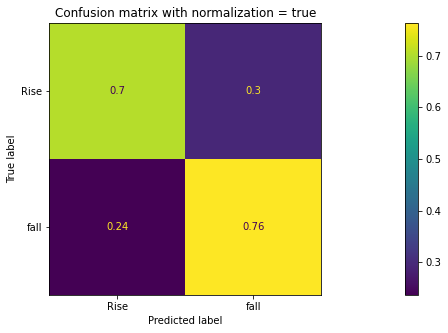

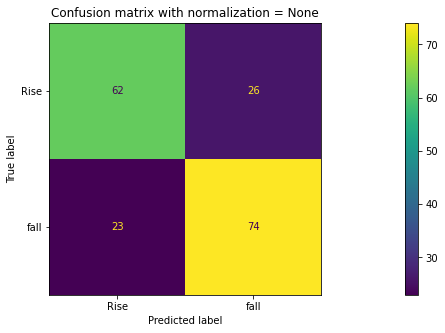

In [21]:
#setup plots for confusion matrix
from sklearn.metrics import plot_confusion_matrix as matrix
figSize = plt.rcParams["figure.figsize"]
figSize[0] = 30
figSize[1] = 5
plt.rcParams["figure.figsize"]=figSize
print(plt.rcParams.get('figure.figsize'))

#plot the confusion matrices 1 for normalzied the other un-normalized
values = ['true',None]
#cmap='cividis'
for x in values:
    disp = matrix(clf,X_test,Y_test,display_labels=sorted,normalize=x)
    disp.ax_.set_title("Confusion matrix with normalization = "+str(x))
print(disp.confusion_matrix)


In [22]:
TP = 52
FP = 29
FN = 33
TN = 71
recall = TP/(TP+FN)
percision= TP/(TP+FP)
fmeasure = (2*recall*percision)/(recall+percision)
print(recall, percision, fmeasure)

0.611764705882353 0.6419753086419753 0.6265060240963856
